# Requirments

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install astropy pandas
! pip install lmfit

import numpy as np
import pandas as pd
from astropy.io import fits

import numpy as np
from lmfit.models import GaussianModel
from lmfit import Parameters

import numpy as np
from skimage.filters import threshold_otsu
import plotly.graph_objects as go
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from astropy.io import fits
import imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 12.6 MB/s eta 0:00:00


# Gaussian Fitting

In [3]:
fits_path = '/content/drive/MyDrive/MastersProjects/DustScatteringHalo/cloud_shape_detection/4U1630_12CO.fits'
hdul = fits.open(fits_path)

# Collecting images, velocities, and brightest pixels
images = []
velocities = []
brightest_pixels = []
pixel_sums = []


# Assuming the images are stored in a 3D array and the velocity calculation is defined
for i in range(500):
    image = hdul[0].data[i]  # Accessing the i-th image
    images.append(image)
    velocity = -175. + i * 0.5 # Calculate the velocity for the i-th image (replace with your calculation)
    velocities.append(velocity)
    brightest_pixel = np.nanmax(image)  # Find the brightest pixel value
    brightest_pixels.append(brightest_pixel)
    pixel_sum = np.nansum(image)
    pixel_sums.append(pixel_sum)

# Create a DataFrame
df = pd.DataFrame({
    'Images': images,
    'Velocities': velocities,
    'Brightest Pixel': brightest_pixels,
    'Pixel Sum': pixel_sums
})


In [4]:
def gauss_fits(xx, yy, nregions, regions, inits, ngauss, max_iters=100):
    # Initialize results
    coefficients = np.zeros((3, ngauss))
    errors = np.zeros((3, ngauss))

    # Define the combined Gaussian model based on `ngauss`
    model = None
    params = Parameters()
    for i in range(ngauss):
        gauss = GaussianModel(prefix=f'g{i}_')
        model = gauss if model is None else model + gauss

        # Initial parameters
        params.add(f'g{i}_amplitude', value=inits[i][0])
        params.add(f'g{i}_center', value=inits[i][1])
        params.add(f'g{i}_sigma', value=inits[i][2] / (2 * np.sqrt(2 * np.log(2))))  # Convert FWHM to sigma

    # Subset the data based on the regions provided
    data_mask = np.zeros_like(yy, dtype=bool)
    for start, end in regions:
        data_mask[start:end+1] = True

    xx = xx[data_mask]
    yy = yy[data_mask]

    # Fit the data
    result = model.fit(yy, params, x=xx, method='chisqr', max_nfev=max_iters)

    # Extract fitted parameters and errors
    for i in range(ngauss):
        coefficients[0, i] = result.params[f'g{i}_amplitude'].value
        coefficients[1, i] = result.params[f'g{i}_center'].value
        coefficients[2, i] = result.params[f'g{i}_sigma'].value * (2 * np.sqrt(2 * np.log(2)))  # Convert sigma to FWHM

        # Check for None values in stderr and handle them
        errors[0, i] = result.params[f'g{i}_amplitude'].stderr if result.params[f'g{i}_amplitude'].stderr is not None else 0
        errors[1, i] = result.params[f'g{i}_center'].stderr if result.params[f'g{i}_center'].stderr is not None else 0
        errors[2, i] = (result.params[f'g{i}_sigma'].stderr * (2 * np.sqrt(2 * np.log(2)))) if result.params[f'g{i}_sigma'].stderr is not None else 0

    return coefficients, errors

# Note: This function checks if stderr is None and replaces it with 0 for the error calculations.


In [5]:
def add_normalized_pixel_sum_column(df):
    # Get min and max pixel sums
    min_pixel_sum = df['Pixel Sum'].min()
    max_pixel_sum = df['Pixel Sum'].max()

    print("min_pixel_sum",min_pixel_sum,"max_pixel_sum",max_pixel_sum)

    # Define the range for normalization
    norm_range = [0, 3.2428885]

    # Calculate normalized pixel sum
    df['Normalized Pixel Sum'] = norm_range[0] + ((df['Pixel Sum'] - min_pixel_sum) * (norm_range[1] - norm_range[0]) / (max_pixel_sum - min_pixel_sum))

    return df

df = add_normalized_pixel_sum_column(df)

min_pixel_sum -21.900393 max_pixel_sum 8442.391


In [6]:
xx = df['Velocities'].values  # Your velocities
yy = df['Pixel Sum'].values  # Your pixel sums

nregions = 15

# Define the list of tuples where each tuple is (start, end) denoting the region of interest
regions = [(-122,-112),
           (-115,-113),
           (-113,-105),
           (-108,-102),
           (-105,-95),
           (-93,-67),
           (-77,-69),
           (-77,-60),
           (-65,-57),
           (-61,-51),
           (-51,-43),
           (-46,-44),
           (-45,-35),
           (-40,-30),
           (-23,-17)]

# Define a 2D array of initial guesses for the Gaussian parameters, e.g. [[amplitude1, center1, FWHM1], [amplitude2, center2, FWHM2], ...]
inits = [
         [795.77, -117, 3],
         [523.48, -114 , 2.5],
         [1100.01, -109 , 3],
         [1817.76, -105.5 ,3],
         [1949.10, -99.5 , 4],
         [8435.25, -80 ,9],
         [4232.85, -74 , 4],
         [1593.69, -67.5 , 10],
         [665.19, -61 , 2],
         [1140.91, -56.5, 4],
         [1026.37, -47.5 , 4.5],
         [1344.50, -42.5 , 2.5],
         [2356.29, -39.5 , 3.5],
         [1341.66, -35 , 4],
         [3556.45, -19.5, 2.5]
         ]


# Define the total number of Gaussians you want to fit
ngauss = 15

# (Optional) Define the maximum number of iterations for the fitting. Default is 1000 if not provided.
max_iters = 3

# Call the function



In [7]:
norm_range = [0, 3.2428885]
min_pixel_sum = df['Pixel Sum'].min()
max_pixel_sum = df['Pixel Sum'].max()

for i in inits:
  i[0] = norm_range[0] + ((i[0]- min_pixel_sum) * (norm_range[1] - norm_range[0]) / (max_pixel_sum - min_pixel_sum))

In [8]:
inits[6][0] = 0.8
inits[8][0] = 0.25
inits[6][0] = 0.52
inits[-1][0] = 1.5

In [9]:
inits

[[0.31327064580350383, -117, 3],
 [0.20894931421944332, -114, 2.5],
 [0.4298328475778421, -109, 3],
 [0.7048214103030962, -105.5, 3],
 [0.7551411564937404, -99.5, 4],
 [3.2401527428683927, -80, 9],
 [0.52, -74, 4],
 [0.6189744061235801, -67.5, 10],
 [0.25, -61, 2],
 [0.44550269392470787, -56.5, 4],
 [0.4016194616369327, -47.5, 4.5],
 [0.5235032811559645, -42.5, 2.5],
 [0.9111461622145292, -39.5, 3.5],
 [0.5224152038057177, -35, 4],
 [1.5, -19.5, 2.5]]

In [10]:
coefficients, errors = gauss_fits(xx, yy, nregions, regions, inits, ngauss, max_iters)

In [11]:
coefficients

array([[   0.31327065,    0.20894931,    0.42983285,    0.70482141,
           0.75514116,    3.24015274,    0.52      ,    0.61897441,
           0.25      ,    0.44550269,    0.40161946,    0.52350328,
           0.91114616,    0.5224152 ,    1.5       ],
       [-117.        , -114.        , -109.        , -105.5       ,
         -99.5       ,  -80.        ,  -74.        ,  -67.5       ,
         -61.        ,  -56.5       ,  -47.5       ,  -42.5       ,
         -39.5       ,  -35.        ,  -19.5       ],
       [   3.15      ,    2.5       ,    3.        ,    3.        ,
           4.        ,    9.        ,    4.        ,   10.        ,
           2.        ,    4.        ,    4.5       ,    2.5       ,
           3.5       ,    4.        ,    2.5       ]])

In [12]:
coeff = coefficients.T.tolist()
coeff

[[0.31327064580350383, -117.0, 3.15],
 [0.20894931421944332, -114.0, 2.5],
 [0.4298328475778421, -109.0, 3.0],
 [0.7048214103030962, -105.5, 3.0],
 [0.7551411564937404, -99.5, 4.0],
 [3.2401527428683927, -80.0, 9.0],
 [0.52, -74.0, 4.0],
 [0.6189744061235801, -67.5, 10.0],
 [0.25, -61.0, 2.0],
 [0.44550269392470787, -56.5, 4.0],
 [0.4016194616369327, -47.5, 4.5],
 [0.5235032811559645, -42.5, 2.5],
 [0.9111461622145292, -39.5, 3.5],
 [0.5224152038057177, -35.0, 4.0],
 [1.5, -19.5, 2.5]]

## Results

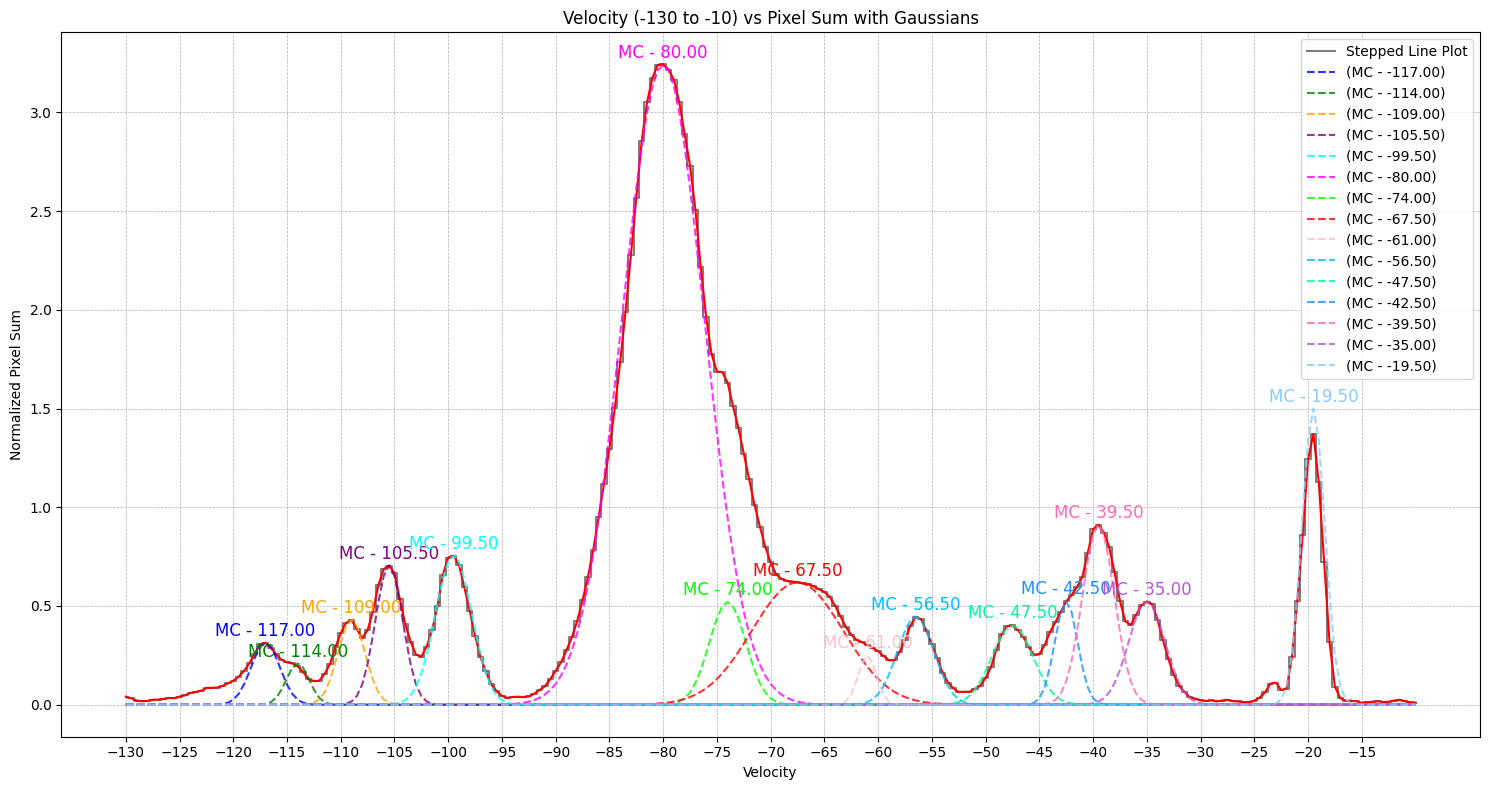

In [13]:
def plot_gaussians(velocities, gaussian_params):

    # Bright colors list with 15 colors
    colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'red', 'pink', 'deepskyblue',
              'mediumspringgreen', 'dodgerblue', 'hotpink', 'mediumorchid', 'lightskyblue']

    for i, (amplitude, center, FWHM) in enumerate(gaussian_params):
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        y_values = amplitude * np.exp(-(velocities - center)**2 / (2 * sigma**2))

        # Plot the Gaussian
        plt.plot(velocities, y_values, linestyle='--', color=colors[i % len(colors)], alpha=0.8, label=f'(MC - {center:.2f})')

        # Annotate the peak with the center velocity value
        peak_y = amplitude  # the peak y value for a Gaussian is its amplitude
        plt.annotate(f"MC - {abs(center):.2f}", (center, peak_y), textcoords="offset points", xytext=(0,5), ha='center', color=colors[i % len(colors)], fontsize=12)



# Sample Gaussian parameters
gaussian_parameters = coeff

# Assuming you have the necessary libraries and data loaded, here's how you can plot the Gaussians on top of your existing plot:

plt.figure(figsize=(15, 8))

filtered_df = df[(df['Velocities'] >= -130) & (df['Velocities'] <= -10)]

# Plotting the existing data
plt.step(filtered_df['Velocities'], filtered_df['Normalized Pixel Sum'], color='black', where='mid', alpha=0.5, label='Stepped Line Plot')
plt.plot(filtered_df['Velocities'], filtered_df['Normalized Pixel Sum'], color='red')

# Plotting the Gaussians
plot_gaussians(filtered_df['Velocities'], gaussian_parameters)

# Remaining plot adjustments
plt.xlabel('Velocity')
plt.ylabel('Normalized Pixel Sum')
plt.title('Velocity (-130 to -10) vs Pixel Sum with Gaussians')
plt.xticks(np.arange(-130, -10, 5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


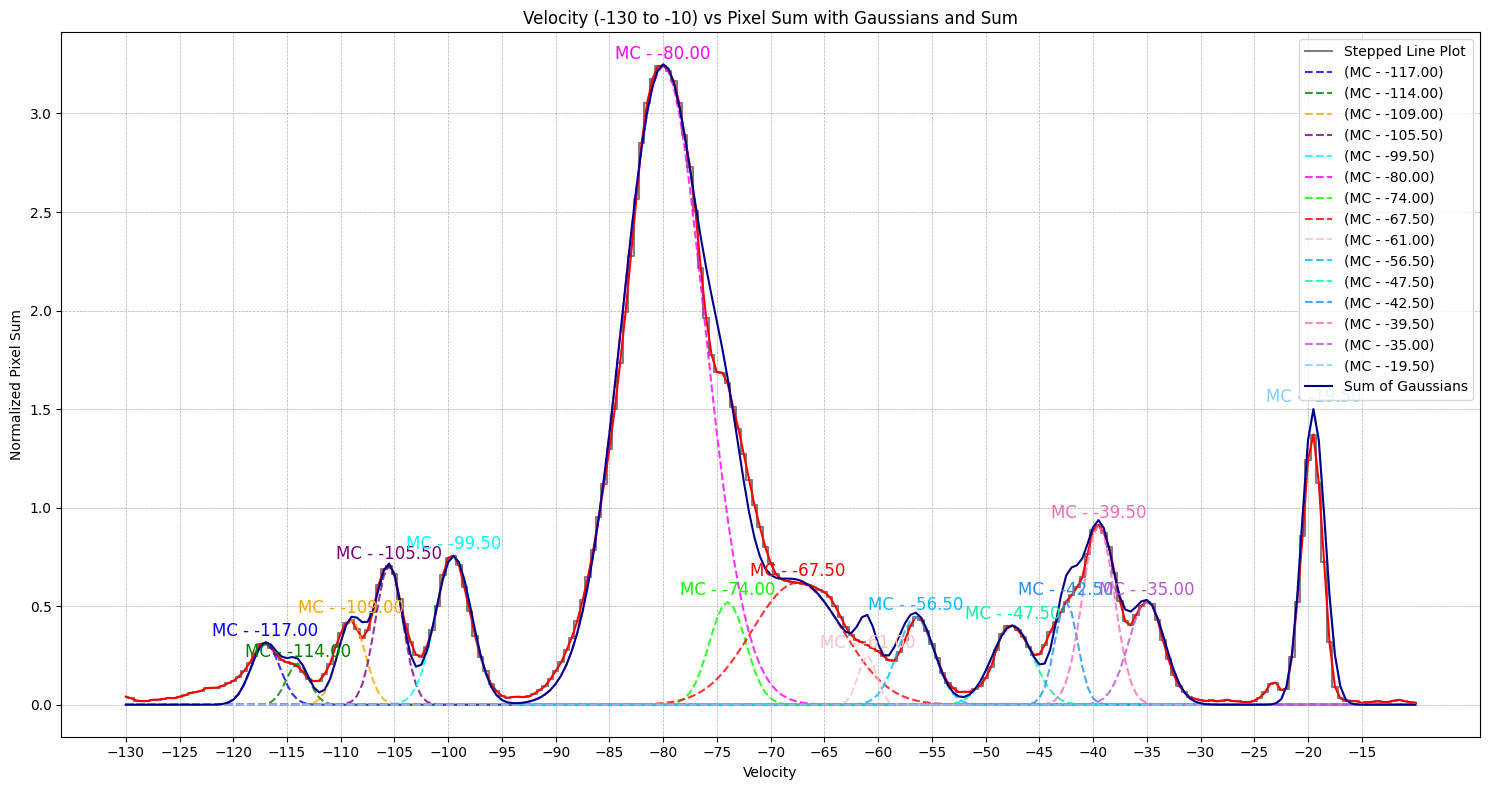

In [14]:
def plot_gaussians_with_sum(velocities, gaussian_params):

    # Bright colors list with 15 colors
    colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'red', 'pink', 'deepskyblue',
              'mediumspringgreen', 'dodgerblue', 'hotpink', 'mediumorchid', 'lightskyblue']

    summed_gaussian = np.zeros_like(velocities)

    for i, (amplitude, center, FWHM) in enumerate(gaussian_params):
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        y_values = amplitude * np.exp(-(velocities - center)**2 / (2 * sigma**2))
        summed_gaussian += y_values

        # Plot the Gaussian
        plt.plot(velocities, y_values, linestyle='--', color=colors[i % len(colors)], alpha=0.8, label=f'(MC - {center:.2f})')

        # Annotate the peak with the center velocity value
        peak_y = amplitude  # the peak y value for a Gaussian is its amplitude
        plt.annotate(f"MC - {center:.2f}", (center, peak_y), textcoords="offset points", xytext=(0,5), ha='center', color=colors[i % len(colors)], fontsize=12)

    # Plot the summed Gaussian
    plt.plot(velocities, summed_gaussian, color='darkblue', label='Sum of Gaussians')

# Assuming you have the necessary libraries and data loaded, here's how you can plot the Gaussians and their sum on top of your existing plot:

plt.figure(figsize=(15, 8))

# Plotting the existing data
plt.step(filtered_df['Velocities'], filtered_df['Normalized Pixel Sum'], color='black', where='mid', alpha=0.5, label='Stepped Line Plot')
plt.plot(filtered_df['Velocities'], filtered_df['Normalized Pixel Sum'], color='red')

# Plotting the Gaussians and their sum
plot_gaussians_with_sum(filtered_df['Velocities'], gaussian_parameters)

# Remaining plot adjustments
plt.xlabel('Velocity')
plt.ylabel('Normalized Pixel Sum')
plt.title('Velocity (-130 to -10) vs Pixel Sum with Gaussians and Sum')
plt.xticks(np.arange(-130, -10, 5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# New Mean-Shift Algorithm


In [15]:
import numpy as np
from scipy.spatial.distance import euclidean
from astropy.io import fits
import numpy as np
from skimage.filters import threshold_otsu
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import imageio

In [16]:
def prepare_data_for_mean_shift(fits_path, start_velocity, end_velocity, use_otsu=True, otsu_mult_factor=1.0, scaling_method='standard'):
    """
    Prepare data for mean-shift clustering.

    Parameters:
        fits_path (str): Path to the FITS file containing the image data.
        start_velocity (float): Starting velocity for the region of interest.
        end_velocity (float): Ending velocity for the region of interest.
        use_otsu (bool): Whether to use Otsu thresholding.
        otsu_mult_factor (float): Multiplier for Otsu threshold.
        scaling_method (str): Method for scaling, either 'standard' or 'minmax'.

    Returns:
        scaled_dataset (array): Scaled dataset ready for clustering, shape (n_samples, n_features)
        scaler (object): Scaler object used for scaling.
    """
    hdul = fits.open(fits_path)
    data_list = []

    # Read image data into data_list
    for i in range(500):
        image = hdul[0].data[i]
        data_list.append(image)

    # Compute Otsu threshold if required
    if use_otsu:
        all_pixel_values = []
        for z, image in enumerate(data_list):
            velocity = -175. + z * 0.5
            if start_velocity <= velocity <= end_velocity:
                min_val = np.nanmin(image)
                image_no_nan = np.where(np.isnan(image), min_val, image)
                all_pixel_values.extend(image_no_nan.ravel())
        global_thresh = threshold_otsu(np.array(all_pixel_values))
        thresh = global_thresh * otsu_mult_factor
    else:
        thresh = 1.7  # Default threshold if not using Otsu

    # Create the dataset
    dataset = []
    for z, image in enumerate(data_list):
        for x in range(image.shape[0]):
            for y in range(image.shape[1]):
                pixel_value = image[x, y]
                if not np.isnan(pixel_value) and (pixel_value > thresh):
                    if start_velocity <= (-175. + z * 0.5) <= end_velocity:
                        dataset.append([x, y, (-175. + z * 0.5), pixel_value])

    dataset = np.array(dataset)

    # Choose the scaling method
    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling_method. Choose either 'standard' or 'minmax'")

    # Scale the dataset
    scaled_dataset = scaler.fit_transform(dataset)

    return scaled_dataset, scaler, dataset


In [17]:
def scale_seeds(seeds, scaler):
    """
    Scale the seed values using a given scaler.

    Parameters:
        seeds (array): Seed points as a 2D NumPy array, shape (n_clusters, n_features)
        scaler (object): Scaler object used for scaling.

    Returns:
        scaled_seeds (array): Scaled seed points, shape (n_clusters, n_features)
    """

    return scaler.transform(seeds)

In [18]:
def mean_shift_clustering(X, seeds, bandwidths, epsilon=1e-3, max_iter=10, fweight_velocity=1, fweight_pixel_value=1, fweight_xy=1):
    """
    Modified Mean Shift Clustering Algorithm with weighted velocity.

    Parameters:
        X (array): Data points as a 2D NumPy array, shape (n_samples, n_features)
        seeds (array): Initial seed points as a 2D NumPy array, shape (n_clusters, n_features)
        bandwidths (array): Bandwidths for each seed point as a 1D NumPy array, shape (n_clusters,)
        weight_velocity (float): Weight to apply to the velocity feature
        epsilon (float): Convergence threshold
        max_iter (int): Maximum number of iterations

    Returns:
        C (array): Cluster centers, shape (n_clusters, n_features)
        labels (array): Cluster labels for each data point, shape (n_samples,)
        A (array): Distance matrix, shape (n_samples, n_clusters)
    """

    weight_velocity = fweight_velocity
    weight_pixel_value = fweight_pixel_value
    weight_xy = fweight_xy

    # Weight the velocity feature
    X_weighted = np.copy(X)
    seeds_weighted = np.copy(seeds)

    # Assuming velocity is the third column (0-indexed)
    X_weighted[:, 0] *= weight_xy
    seeds_weighted[:, 0] *= weight_xy
    X_weighted[:, 1] *= weight_xy
    seeds_weighted[:, 1] *= weight_xy

    # Assuming velocity is the third column (0-indexed)
    X_weighted[:, 2] *= weight_velocity
    seeds_weighted[:, 2] *= weight_velocity

    # Assuming velocity is the third column (0-indexed)
    X_weighted[:, 3] *= weight_pixel_value
    seeds_weighted[:, 3] *= weight_pixel_value


    # Initialize cluster centers as seeds
    C = np.copy(seeds_weighted)

    # Initialize distance matrix A
    n_samples, n_features = X.shape
    n_clusters = len(seeds)
    A = np.zeros((n_samples, n_clusters))

    # Main loop for each seed point
    for i in range(n_clusters):
        s_i = seeds_weighted[i]
        b_i = bandwidths[i]
        for _ in range(max_iter):
            # Initialize neighbors within bandwidth
            N = []
            for x_j in X_weighted:
                d = euclidean(s_i, x_j)
                if d < b_i:
                    N.append(x_j)

            if len(N) == 0:
                break

            # Calculate the shift vector M
            N = np.array(N)
            weights = np.exp(-np.sum((N - s_i)**2, axis=1) / (2 * b_i**2))
            M = np.sum(weights[:, None] * N, axis=0) / np.sum(weights)

            # Check for convergence
            if euclidean(s_i, M) < epsilon:
                break

            # Update the seed point
            s_i = M

        # Update cluster center
        C[i] = s_i

    # Fill distance matrix A and assign clusters
    labels = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        for j in range(n_clusters):
            A[i, j] = euclidean(X_weighted[i], C[j])
        labels[i] = np.argmin(A[i])

    # Revert the weighting on the final cluster centers for interpretability
    C[:, 2] /= weight_velocity
    C[:, 3] /= weight_pixel_value

    return C, labels, A

In [19]:
def calculate_B_matrix(A, method='inverse_distance'):
    """
    Calculate the B matrix from the A distance matrix using different methods.

    Parameters:
        A (array): Distance matrix, shape (n_samples, n_clusters)
        method (str): Method for calculating B, one of ['inverse_distance', 'gaussian_kernel', 'softmax']

    Returns:
        B (array): Matrix with percentage of each data point belonging to each cluster, shape (n_samples, n_clusters)
    """
    n_samples, n_clusters = A.shape
    B = np.zeros((n_samples, n_clusters))

    for i in range(n_samples):
        if method == 'inverse_distance':
            B[i, :] = 1 / A[i, :]
            B[i, :] /= np.sum(B[i, :])

        elif method == 'gaussian_kernel':
            B[i, :] = np.exp(-A[i, :] ** 2)
            if np.sum(B[i, :]) == 0:
                B[i, :] = 1.0 / len(B[i, :])  # Uniform distribution across clusters
            else:
                B[i, :] /= np.sum(B[i, :])

        elif method == 'softmax':
            B[i, :] = np.exp(-A[i, :])
            B[i, :] /= np.sum(B[i, :])

    return B

In [20]:
def multi_label_mean_shift(X, seeds, bandwidths, epsilon=1e-3, max_iter=100,
                           weighting_method='inverse_distance', alpha=0.6, beta=0.1, fweight_velocity=1,fweight_pixel_value=1,fweight_xy=1):
    """
    Multi-label Mean Shift clustering with soft assignments.

    Parameters:
        All parameters from mean_shift_clustering
        weighting_method (str): Method for calculating B matrix, one of ['inverse_distance', 'gaussian_kernel', 'softmax']
        alpha (float): Threshold for max probability to assign single label
        beta (float): Threshold for minimum probability to consider for multi-label assignment

    Returns:
        C (array): Cluster centers, shape (n_clusters, n_features)
        labels (list): Cluster labels for each data point, can be multi-label
        A (array): Distance matrix, shape (n_samples, n_clusters)
        B (array): Soft assignment matrix, shape (n_samples, n_clusters)
    """

    # First, run the modified mean_shift_clustering to get C, labels, and A
    C, _, A = mean_shift_clustering(X, seeds, bandwidths, epsilon, max_iter, fweight_velocity, fweight_pixel_value,fweight_xy)

    # Calculate B matrix based on A and the selected weighting method
    B = calculate_B_matrix(A, method=weighting_method)

    # Initialize labels list
    labels = []

    # Assign labels based on B matrix, alpha and beta
    for i in range(len(X)):
        max_prob = np.max(B[i])
        if max_prob >= alpha:
            # Assign the single label corresponding to max probability
            labels.append([np.argmax(B[i])])
        else:
            # Find the probabilities above and below the beta threshold
            above_beta_indices = np.where(B[i] >= beta)[0]
            below_beta_indices = np.where(B[i] < beta)[0]

            # Sum up the probabilities below the beta threshold
            sum_below_beta = np.sum(B[i, below_beta_indices])

            # Redistribute the summed probabilities to those above beta, based on their existing values
            sum_above_beta = np.sum(B[i, above_beta_indices])
            redistributed_probs = B[i, above_beta_indices] + (B[i, above_beta_indices] / sum_above_beta) * sum_below_beta

            # Create a list of tuples containing the cluster label and its updated probability
            updated_labels_probs = list(zip(above_beta_indices, redistributed_probs))

            # Ensure the probabilities sum up to 1 (due to numerical inaccuracies)
            total_prob = sum(prob for label, prob in updated_labels_probs)
            updated_labels_probs = [(label, prob / total_prob) for label, prob in updated_labels_probs]

            labels.append(updated_labels_probs)

            if updated_labels_probs == []:
              print("max",max_prob," matrix",B[i]," redistributedprobs",redistributed_probs," updatedprobs",updated_labels_probs,"total",total_prob)


    return C, labels, A, B


In [21]:
from collections import Counter
import plotly.graph_objects as go
import numpy as np

def plot_3d_clusters_interactive(data, labels, n_biggest=32, point_size=3, x_range=[0,45], y_range=[0,45], z_range=None):
    label_counts = Counter(labels)
    print(label_counts)
    sorted_clusters = [item[0] for item in label_counts.most_common(n_biggest)]

    traces = []
    for cluster in sorted_clusters:
        mask = np.array([label == cluster for label in labels])
        filtered_data = data[mask, :]
        trace = go.Scatter3d(
            x=filtered_data[:, 0],
            y=filtered_data[:, 1],
            z=filtered_data[:, 2],
            mode='markers',
            marker=dict(size=point_size),
            name=f'Cluster {cluster}'
        )
        traces.append(trace)

    layout = go.Layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Velocity',
            xaxis_range=x_range,  # Set the x-axis range
            yaxis_range=y_range,  # Set the y-axis range
            zaxis_range=z_range   # Set the z-axis range
        )
    )

    fig = go.Figure(data=traces, layout=layout)
    fig.show()


In [22]:
import plotly.graph_objects as go
from collections import Counter
import numpy as np

def plot_3d_clusters_individual(seeds, df, n_biggest=32, point_size=4, x_range=[0, 45], y_range=[0, 45], z_range=None):
    label_counts = Counter(df['label'])
    print(label_counts)
    sorted_clusters = [item[0] for item in label_counts.most_common(n_biggest)]

    min_value = df['pixel_value'].min()
    max_value = df['pixel_value'].max()

    # Apply Min-Max scaling to the
    df['pixel_value'] = (df['pixel_value'] - min_value) / (max_value - min_value)


    for cluster in sorted_clusters:
        # Filter data by label
        filtered_data = df[df['label'] == cluster]

        # Extract x, y, z, and pixel brightness
        x_data = filtered_data['x']
        y_data = filtered_data['y']
        z_data = filtered_data['velocity']
        brightness_data = filtered_data['pixel_value']

        # Create a colormap based on pixel brightness
        colormap = brightness_data

        trace = go.Scatter3d(
            x=x_data,
            y=y_data,
            z=z_data,
            mode='markers',
            marker=dict(
                size=point_size,
                color=colormap,  # Use pixel brightness for color
                colorscale='Plasma',  # Choose a colorscale
                colorbar=dict(title='Brightness'),  # Add color bar with title
            ),
            name=f'Cluster {cluster}'
        )

        layout = go.Layout(
            margin=dict(l=0, r=0, b=0, t=0),
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Velocity',
                xaxis_range=x_range,
                yaxis_range=y_range,
                zaxis_range=z_range,
                aspectratio=dict(x=1, y=1, z=1.5)
            )
        )

        fig = go.Figure(data=[trace], layout=layout)
        fig.show()

        html_filename = f"MC-{abs(seeds[cluster][2])}.html"
        fig.write_html(html_filename)


##### plotting

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_gaussians(velocities, gaussian_params, agg_data=None):
    # Bright colors list with 15 colors
    colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'red', 'pink', 'deepskyblue',
              'mediumspringgreen', 'dodgerblue', 'hotpink', 'mediumorchid', 'lightskyblue']

    # If aggregated data is provided, plot it
    if agg_data is not None:
        for label, group in agg_data.groupby('label'):
            plt.plot(group['velocity'], group['pixel_value'], 'o', label=f'Cluster {label}')

    for i, (amplitude, center, FWHM) in enumerate(gaussian_params):
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        y_values = amplitude * np.exp(-(velocities - center)**2 / (2 * sigma**2))

        # Plot the Gaussian
        plt.plot(velocities, y_values, linestyle='--', color=colors[i % len(colors)], alpha=0.8)

        # Annotate the peak with the center velocity value
        peak_y = amplitude  # the peak y value for a Gaussian is its amplitude
        plt.annotate(f"MC - {abs(center):.2f}", (center, peak_y), textcoords="offset points", xytext=(0,5), ha='center', color=colors[i % len(colors)], fontsize=12)


def aggregate_data(dataset, labels):

  df = pd.DataFrame(dataset, columns=['x', 'y', 'velocity', 'pixel_value'])
  df['label'] = labels
  """
  new_rows_list = []

  for index, row in df.iterrows():

      if len(row['label']) == 1:
          single_label = row['label'][0]
          if isinstance(single_label, tuple):
            df.at[index, 'label'] = int(single_label[0])
          else:
            df.at[index, 'label'] = int(single_label)
      else:
          for item in row['label']:
              new_row = row.copy()
              new_row['label'] = item[0]
              new_row['pixel_value'] *= item[1]
              new_rows_list.append(new_row)

          df.drop(index, inplace=True)

  # Create a new DataFrame from the list of new rows
  new_rows_df = pd.DataFrame(new_rows_list)

  # Concatenate the original DataFrame and the new rows, then reset the index
  df = pd.concat([df, new_rows_df]).reset_index(drop=True)
  """
  # Sort by 'velocity'
  df.sort_values(by=['velocity','x'], inplace=True)

  aggregated = df.groupby(['velocity', 'label'])['pixel_value'].sum().reset_index()

  aggregated['pixel_value'] = norm_range[0] + ((aggregated['pixel_value'] - min_pixel_sum) * (norm_range[1] - norm_range[0]) / (max_pixel_sum - min_pixel_sum))

  total_sum_by_velocity = df.groupby('velocity')['pixel_value'].sum().reset_index()
  total_sum_by_velocity['pixel_value'] = norm_range[0] + ((total_sum_by_velocity['pixel_value'] - min_pixel_sum) * (norm_range[1] - norm_range[0]) / (max_pixel_sum - min_pixel_sum))
  total_sum_by_velocity['label'] = 'total'
  aggregated = pd.concat([aggregated, total_sum_by_velocity], ignore_index=True)

  return aggregated,df


In [24]:
def label_converter(labels):

  mapping_list = {
    (0,) : 0, (1,) : 1, (2,) : 2, (3,) : 3, (4,) : 4,
    (0,1) : 5, (0,2) : 6, (0,3) : 7, (0,4) : 8,
    (1,2) : 9, (1,3) : 10, (1,4) : 11, (2,3) : 12,
    (2,4) : 13, (3,4) : 14, (0,1) : 15,
    (0,1,2) : 16, (0,1,3) : 17, (0,1,4) : 18,
    (0,2,3) : 19, (0,2,4) : 20, (0,3,4) : 21,
    (1,2,3) : 22, (1,2,4) : 23, (1,3,4) : 24,
    (2,3,4) : 25,
    (0,1,2,3) : 26, (0,1,2,4) : 27, (0,1,3,4) : 28,
    (0,2,3,4) : 29, (1,2,3,4) : 30, (0,1,2,3,4,5) :31
    }

  new_labels = []
  for i in labels:
      if len(i) == 0:  # Handle empty labels
          new_labels.append(-1)
      elif len(i) == 1:
          if isinstance(i[0], tuple):
              new_labels.append(mapping_list.get((i[0][0],), -1))  # convert list to tuple
          else:
              new_labels.append(mapping_list.get((i[0],), -1))  # convert list to tuple
      else:
          l = tuple(j[0] for j in i)  # create a tuple of the first elements
          new_labels.append(mapping_list.get(l, -1))

  return new_labels

In [25]:
def plot_spectrum(dataset,labels, show_sum = False):

    aggregated,df = aggregate_data(dataset, labels)
    filtered_agg = aggregated[aggregated['label'] == 'total']
    aggregated = aggregated[aggregated['label'] != 'total']

    # Plotting
    plt.figure(figsize=(15, 8))
    plot_gaussians(filtered_df['Velocities'], gaussian_parameters, agg_data=aggregated)


    if show_sum:
      plt.plot(filtered_df['Velocities'], filtered_df['Normalized Pixel Sum'], color='red')
      #plt.plot(filtered_agg['velocity'], filtered_agg['pixel_value'], color='black')


    # Remaining plot adjustments
    plt.xlabel('Velocity')
    plt.ylabel('Pixel Sum')
    plt.title('Velocity vs Pixel Sum with Gaussians and Clustered Data')
    plt.xticks(np.arange(-130, -10, 5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df

In [26]:
def create_output_file(seeds, agg_df, FITS = False):

  agg_df.sort_values(by=['label','velocity','x','y'], inplace=True)

  if FITS:

    """
    grouped_by_label = agg_df.groupby('label')

    for label, group in grouped_by_label:
      # Group by 'velocity' within each label group
      grouped_by_velocity = group.groupby('velocity')

      # Create a FITS HDUList to store all images for this label
      hdul = fits.HDUList()

      for velocity, velocity_group in grouped_by_velocity:
        # Create an empty 2D array for the image
        image_data = np.full((53,49),np.nan)

        # Populate the image data from the DataFrame
        for _, row in velocity_group.iterrows():
            x, y, pixel_value = int(row['x']), int(row['y']), row['pixel_value']
            image_data[x][y] = pixel_value

        # Create an ImageHDU for this velocity and append to HDUList
        hdu = fits.ImageHDU(image_data, header=fits.Header({'VELOCITY': velocity}))
        hdul.append(hdu)

      # Save the HDUList to a FITS file
      hdul.writeto(f'MC-{abs(seeds[label][2])}.fits', overwrite=True)
      """

    grouped_by_label = agg_df.groupby('label')

    for label, group in grouped_by_label:
      # Group by 'velocity' within each label group
      grouped_by_velocity = group.groupby('velocity')

      # Create an empty 2D array for the final image
      final_image_data = np.full((53, 49), np.nan)

      for velocity, velocity_group in grouped_by_velocity:
        # Create an empty 2D array for the image
        image_data = np.full((53, 49), np.nan)

        # Populate the image data from the DataFrame
        for _, row in velocity_group.iterrows():
          x, y, pixel_value = int(row['x']), int(row['y']), row['pixel_value']
          image_data[x, y] = pixel_value

        # Add the current image data to the final image data
        np.nansum([final_image_data, image_data], axis=0, out=final_image_data)

      # Create an ImageHDU with the final image data and save it to a FITS file
      hdu = fits.ImageHDU(final_image_data, header=fits.Header({'CLOUD': seeds[label][2]}))
      primary_hdu = fits.PrimaryHDU()  # create a primary HDU
      hdul = fits.HDUList([primary_hdu, hdu])  # append your ImageHDU to the HDUList
      hdul.writeto(f'MC-{abs(seeds[label][2])}.fits', overwrite=True)


  else:

    grouped = agg_df.groupby('label')

    for label, group in grouped:

      group['x'] = group['x'].astype(int)
      group['y'] = group['y'].astype(int)

      group = group.drop(columns=['label'])

      filename = f'data_MC-{abs(seeds[label][2])}.txt'
      with open(filename, 'w') as file:
          for index, row in group.iterrows():
              line = ', '.join(row.astype(str).values)
              file.write(line + '\n')


######extractor


In [27]:
def extractor_function(scaled_dataset, original_dataset,
                       scaler, extractor_file_names, extractor_selector,
                       scaled_seeds, seeds, bandwidths):

    # Initialize an empty dataframe to store data from all files
    combined_df = pd.DataFrame()

    # Read all the files and append all the data in a dataset
    for file_name in extractor_file_names:
        temp_df = pd.read_csv(file_name, sep=",", header=None)
        temp_df.columns = ['x', 'y', 'velocity', 'pixel_value']
        combined_df = combined_df.append(temp_df)

    # Convert original_dataset to DataFrame for efficient operations
    original_df = pd.DataFrame(original_dataset, columns=['x', 'y', 'velocity', 'pixel_value'])

    # For each row in combined_df, subtract the pixel_value from matching rows in original_df
    for _, row in combined_df.iterrows():
        mask = (original_df['x'] == row['x']) & \
               (original_df['y'] == row['y']) & \
               (original_df['velocity'] == row['velocity'])
        original_df.loc[mask, 'pixel_value'] -= row['pixel_value']

    # Delete rows where pixel value is 0
    original_df = original_df[original_df['pixel_value'] > 0.000001]

    # Convert original_df back to list of lists
    original_dataset = original_df.values.tolist()

    # Scale the dataset using the provided scaler
    scaled_dataset = scaler.transform(original_dataset)

    # Updating seeds, scaled_seeds, and bandwidths
    scaled_seeds = [scaled_seeds[i] for i in extractor_selector]
    seeds = [seeds[i] for i in extractor_selector]
    bandwidths = [bandwidths[i] for i in extractor_selector]

    return scaled_dataset, original_dataset, scaled_seeds, seeds, bandwidths


In [28]:
from collections import Counter
import plotly.graph_objects as go


def perform_multi_label_mean_shift(fits_path, start_velocity, end_velocity,
                                   seeds, bandwidths, use_otsu=True, otsu_mult_factor=1.0,
                                   scaling_method='standard', epsilon=1e-3, max_iter=100,
                                   weighting_method='gaussian_kernel', alpha=0.6, beta=0.1,
                                   plot = False, fweight_velocity=1, fweight_pixel_value=1,
                                   fweight_xy=1,comparison = False, show_sum = False, GIF = False,
                                   output=False,FITS=False, extractor=False,
                                   extractor_file_names = None, extractor_selector= None):
    """
    Perform multi-label mean shift clustering on image data from a FITS file.

    Parameters:
        All parameters from prepare_data_for_mean_shift and multi_label_mean_shift

    Returns:
        C (array): Cluster centers, shape (n_clusters, n_features)
        labels (list): Cluster labels for each data point, can be multi-label
        A (array): Distance matrix, shape (n_samples, n_clusters)
        B (array): Soft assignment matrix, shape (n_samples, n_clusters)
    """

    # Step 1: Prepare the data
    scaled_dataset, scaler, original_dataset = prepare_data_for_mean_shift(fits_path, start_velocity, end_velocity,
                                                         use_otsu, otsu_mult_factor, scaling_method)

    # Step 2: Scale the seeds
    scaled_seeds = scale_seeds(seeds, scaler)

    if extractor == True:
      scaled_dataset,original_dataset,scaled_seeds,seeds,bandwidths = extractor_function(scaled_dataset,original_dataset,
                                                                                         scaler,extractor_file_names,
                                                                                         extractor_selector,scaled_seeds,
                                                                                         seeds,bandwidths)

    # Step 3: Perform multi-label mean shift clustering
    C, labels, A, B = multi_label_mean_shift(scaled_dataset, scaled_seeds, bandwidths, epsilon,
                                             max_iter, weighting_method, alpha, beta,
                                             fweight_velocity, fweight_pixel_value,fweight_xy)

    new_labels = label_converter(labels)

    # Step 4: Plot the clustering results using the original dataset
    if plot == True:
      plot_3d_clusters_interactive(original_dataset, new_labels, z_range = [start_velocity-15,end_velocity+15])

    agg_df = plot_spectrum(original_dataset,labels, show_sum)

    if plot == True:
      plot_3d_clusters_individual(seeds, agg_df, z_range = [start_velocity-15,end_velocity+15])

    if comparison == True:
      plot_comparison(fits_path, original_dataset, agg_df, start_velocity, end_velocity)

    if GIF == True:
      plot_GIF_comparison(fits_path, original_dataset, agg_df, start_velocity, end_velocity)

    if output == True:
      create_output_file(seeds,agg_df,FITS)



    return C, labels, A, B, original_dataset, scaler, labels, new_labels

In [29]:
def plot_comparison(fits_path, original_dataset, agg_df, start_velocity, end_velocity):

    hdul = fits.open(fits_path)
    data_list = []

    # Read image data into data_list
    for i in range(500):
        image = hdul[0].data[i]
        data_list.append(image)

    unique_labels = agg_df['label'].unique()

    for velocity in np.arange(start_velocity, end_velocity+0.5, 0.5):

        original_filtered = original_dataset[original_dataset[:, 2] == velocity]
        agg_filtered = agg_df[agg_df['velocity'] == velocity]

        fig, axes = plt.subplots(1, 2+len(unique_labels), figsize=(15, 5))

        index = (velocity + 175)*2

        # Plot image from data_list
        axes[0].imshow(data_list[int(index)], cmap='hot', origin='lower')
        axes[0].set_title(f"Original image at v={velocity}")

        if has_unexpected_empty_lines(data_list[int(index)]):
          print("empty lines in the original data.")

        img_shape = data_list[int(index)].shape
        img_matrix_original = np.full(img_shape, np.nan)

        for row in original_filtered:
            img_matrix_original[int(row[0]), int(row[1])] = row[3]

        axes[1].imshow(img_matrix_original, cmap='hot', origin='lower')
        axes[1].set_title(f"Filtered image at v={velocity}")

        if has_unexpected_empty_lines(img_matrix_original):
          print("empty lines in the filtered data.")


        # Plot images from agg_df grouped by label
        for i, label in enumerate(unique_labels):
            grouped_pixels = agg_filtered[agg_filtered['label'] == label]
            img_matrix = np.full(img_shape, np.nan)  # Replace with actual dimensions
            for _, row in grouped_pixels.iterrows():
                img_matrix[int(row['x']), int(row['y'])] = row['pixel_value']
            axes[i+2].imshow(img_matrix, cmap='hot', origin='lower')
            axes[i+2].set_title(f"Label {label} at v={velocity}")

            if has_unexpected_empty_lines(img_matrix_original):
              print("empty lines in the grouped data.",i+2)

        plt.show()
        plt.close(fig)

    plt.close(fig)




In [30]:
import numpy as np

def has_unexpected_empty_lines(data, threshold=10):
    """
    Checks if the given 2D numpy array has any row or column that is empty,
    while its adjacent lines have a contiguous segment of non-NaN values of length >= threshold.

    Parameters:
    - data: 2D numpy array
    - threshold: minimum length of contiguous non-NaN segment in adjacent lines to consider a line as unexpectedly empty

    Returns:
    - bool: True if unexpected empty lines are found, False otherwise
    """
    if not isinstance(data, np.ndarray):
        raise ValueError("Input should be a 2D numpy array")

    if len(data.shape) != 2:
        raise ValueError("Input should be a 2D numpy array")

    def find_segments(line):
        """Find contiguous non-NaN segments in a line, returning a list of slice objects."""
        isnan = np.isnan(line)
        segment_starts = np.where(~isnan & np.roll(isnan, 1))[0]
        segment_ends = np.where(~isnan & np.roll(isnan, -1))[0] + 1
        if not isnan[0]:
            segment_starts = np.concatenate(([0], segment_starts))
        if not isnan[-1]:
            segment_ends = np.concatenate((segment_ends, [len(line)]))
        return [slice(start, end) for start, end in zip(segment_starts, segment_ends)]

    def check_lines(start, stop, axis):
        for i in range(start, stop):  # Skip the first and last lines
            if axis == 0:
                line = data[i, :]
                line_above = data[i - 1, :]
                line_below = data[i + 1, :]
            else:
                line = data[:, i]
                line_above = data[:, i - 1]
                line_below = data[:, i + 1]

            if np.all(np.isnan(line)):
                segments_above = find_segments(line_above)
                segments_below = find_segments(line_below)
                for seg_above in segments_above:
                    for seg_below in segments_below:
                        if seg_above.start >= seg_below.start and seg_above.stop <= seg_below.stop and seg_above.stop - seg_above.start >= threshold:
                            return True
        return False

    # Check rows
    if data.shape[0] >= 3:  # Skip if there are less than 3 rows
        if check_lines(1, data.shape[0] - 1, axis=0):
            return True

    # Check columns
    if data.shape[1] >= 3:  # Skip if there are less than 3 columns
        if check_lines(1, data.shape[1] - 1, axis=1):
            return True

    return False


In [31]:
# Create a GIF for a list of images
def create_gif(image_list, filename):
    imageio.mimsave(filename, image_list, duration = 200)

# Function to plot and save frames for GIFs
def plot_GIF_comparison(fits_path, original_dataset, agg_df, start_velocity, end_velocity):

    hdul = fits.open(fits_path)
    data_list = []

    # Read image data into data_list
    for i in range(500):
        image = hdul[0].data[i]
        data_list.append(image)

    unique_labels = agg_df['label'].unique()

    # Initialize list to store frames for GIF
    gif_frames = []

    for velocity in np.arange(start_velocity, end_velocity+0.5, 0.5):

        original_filtered = original_dataset[original_dataset[:, 2] == velocity]
        agg_filtered = agg_df[agg_df['velocity'] == velocity]

        fig, axes = plt.subplots(1, 2+len(unique_labels), figsize=(16, 5))

        index = (velocity + 175)*2

        # For demonstration, using some arbitrary min and max values
        # Replace these with the actual min and max values you want to use for the color scale
        vmin_val = 0
        vmax_val = 1

        # Plot image from data_list
        im1 = axes[0].imshow(data_list[int(index)], cmap='hot', vmin=vmin_val, vmax= vmax_val)
        axes[0].set_title(f"Original image at v={velocity}")

        img_shape = data_list[int(index)].shape
        img_matrix_original = np.full(img_shape, np.nan)

        for row in original_filtered:
            img_matrix_original[int(row[0]), int(row[1])] = row[3]

        im2 = axes[1].imshow(img_matrix_original, cmap='hot')
        axes[1].set_title(f"Filtered image at v={velocity}")

        # Plot images from agg_df grouped by label
        for i, label in enumerate(unique_labels):
            grouped_pixels = agg_filtered[agg_filtered['label'] == label]
            img_matrix = np.full(img_shape, np.nan)  # Replace with actual dimensions
            for _, row in grouped_pixels.iterrows():
                img_matrix[int(row['x']), int(row['y'])] = row['pixel_value']
            im = axes[i+2].imshow(img_matrix, cmap='hot')
            axes[i+2].set_title(f"Label {label} at v={velocity}")

        # Save frame for GIF
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        gif_frames.append(image)

        plt.close(fig)

    # Create GIF
    create_gif(gif_frames, 'plots_for_vel_'+str(start_velocity)+'-'+str(end_velocity)+'.gif')



# Results


## MC 20

In [ ]:
scaled_dataset, scaler, original_dataset = prepare_data_for_mean_shift(fits_path, -25, -15,
                                                         use_otsu, otsu_mult_factor, scaling_method)

In [ ]:
seeds = [[ 2, 18, -20, 16.267826 ]]

## MC 117 - 114

In [69]:
from sklearn.mixture import GaussianMixture

In [32]:
seeds = [[36, 28, -117, 4.000822],
         [3, 34, -114, 4.590847	]]

In [33]:
start_velocity = -121
end_velocity = -111.5

In [34]:
scaled_dataset, scaler, original_dataset = prepare_data_for_mean_shift(fits_path, start_velocity, end_velocity,
                                                         use_otsu=True, otsu_mult_factor=0.3, scaling_method='standard')

In [35]:
scaled_dataset

array([[-1.51688173,  0.76796836, -1.84439141, -0.30676309],
       [-1.51688173,  0.92794799, -1.84439141, -0.09331445],
       [-1.51688173,  1.0079378 , -1.84439141, -0.09331435],
       ...,
       [ 1.90418184,  0.52799893,  2.06483266, -0.66648479],
       [ 1.90418184,  0.60798874,  2.06483266, -0.06864133],
       [ 1.97399947, -0.9918075 ,  2.06483266, -0.31494764]])

In [114]:
scaled_dataset[:, 2] = scaled_dataset[:, 2] * 3

In [36]:
scaled_seeds = scale_seeds(seeds, scaler)

In [37]:
scaled_seeds

array([[ 0.92673511,  0.60798874, -0.19840233,  5.70813139],
       [-1.37724648,  1.08792761,  1.03608948,  6.7041252 ]])

In [115]:
scaled_seeds[:, 2] = scaled_seeds[:, 2] * 3

In [106]:
gmm_default = GaussianMixture()
gmm_default.fit(scaled_dataset)

# Printing the number of components, means, and weights for the default model
default_n_components = gmm_default.n_components
default_means = gmm_default.means_
default_weights = gmm_default.weights_


In [107]:
# Getting the labels and probabilities for each data point after re-training
labels = gmm_default.predict(scaled_dataset)
retrained_probabilities = gmm_default.predict_proba(scaled_dataset)


In [109]:
n_clusters = 2  # Number of clusters

# Creating a GMM model with custom parameters
gmm_custom = GaussianMixture(n_components=n_clusters,
                             means_init=scaled_seeds)
gmm_custom.fit(scaled_dataset)


# Getting the labels and probabilities for each data point after re-training
labels = gmm_custom.predict(scaled_dataset)
retrained_probabilities = gmm_custom.predict_proba(scaled_dataset)

In [111]:
from sklearn.mixture import BayesianGaussianMixture

n_clusters = 2

bgmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='diag',
                               weight_concentration_prior_type='dirichlet_process',
                               weight_concentration_prior=0.01)
bgmm.fit(scaled_dataset)

# Getting the labels and probabilities for each data point
labels = bgmm.predict(scaled_dataset)
probabilities = bgmm.predict_proba(scaled_dataset)


In [39]:
pip install hdbscan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039287 sha256=9f741c613c72cb83be7a3fc9661abf0b5f41241933994f9cb326ae00fd8e1e25
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.7
    Uninstalling Cython-3.0.7:
      Successfully uninstalled Cython-3.0.7


In [44]:
import hdbscan

# HDBSCAN has several parameters that can be tuned. Here are some key parameters:
# - min_cluster_size: The minimum size of clusters; defaults to 5
# - min_samples: The number of samples in a neighborhood for a point to be considered a core point;
#                also controls the degree of robustness against noise and outliers
# - cluster_selection_epsilon: A distance threshold. Clusters below this value will be merged; defaults to 0.0
# - cluster_selection_method: The method to use for selecting clusters from the condensed tree.
#                             The standard method is 'eom' (Excess of Mass)
# - alpha: A distance scaling parameter as used in robust single linkage.
#          Smaller values result in more clusters; defaults to 1.0

# For this example, we'll use the defaults for most parameters and just set min_cluster_size
min_cluster_size = 2  # Example value, you may need to adjust this based on your dataset

# Creating and fitting the HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,alpha=10.0)
hdbscan_labels = hdbscan_model.fit_predict(scaled_dataset)

In [53]:
from sklearn.cluster import SpectralClustering
import numpy as np

n_clusters = 2  # Number of clusters to specify

# Creating and fitting the Spectral Clustering model
spectral_model = SpectralClustering(n_clusters=n_clusters, gamma=10.0)
spectral_labels = spectral_model.fit_predict(scaled_dataset)

spectral_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [45]:
hdbscan_labels

array([119, 119, 119, ...,  -1,  -1,  -1])

In [56]:
retrained_labels

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
default_n_components

1

In [50]:
default_means

array([[ 1.43943831e-17,  5.75775324e-17,  1.07478060e-15,
        -6.71737878e-17]])

In [51]:
default_weights

array([1.])

In [ ]:
plot_3d_clusters_interactive(original_dataset, retrained_labels, z_range = [start_velocity-15,end_velocity+15])

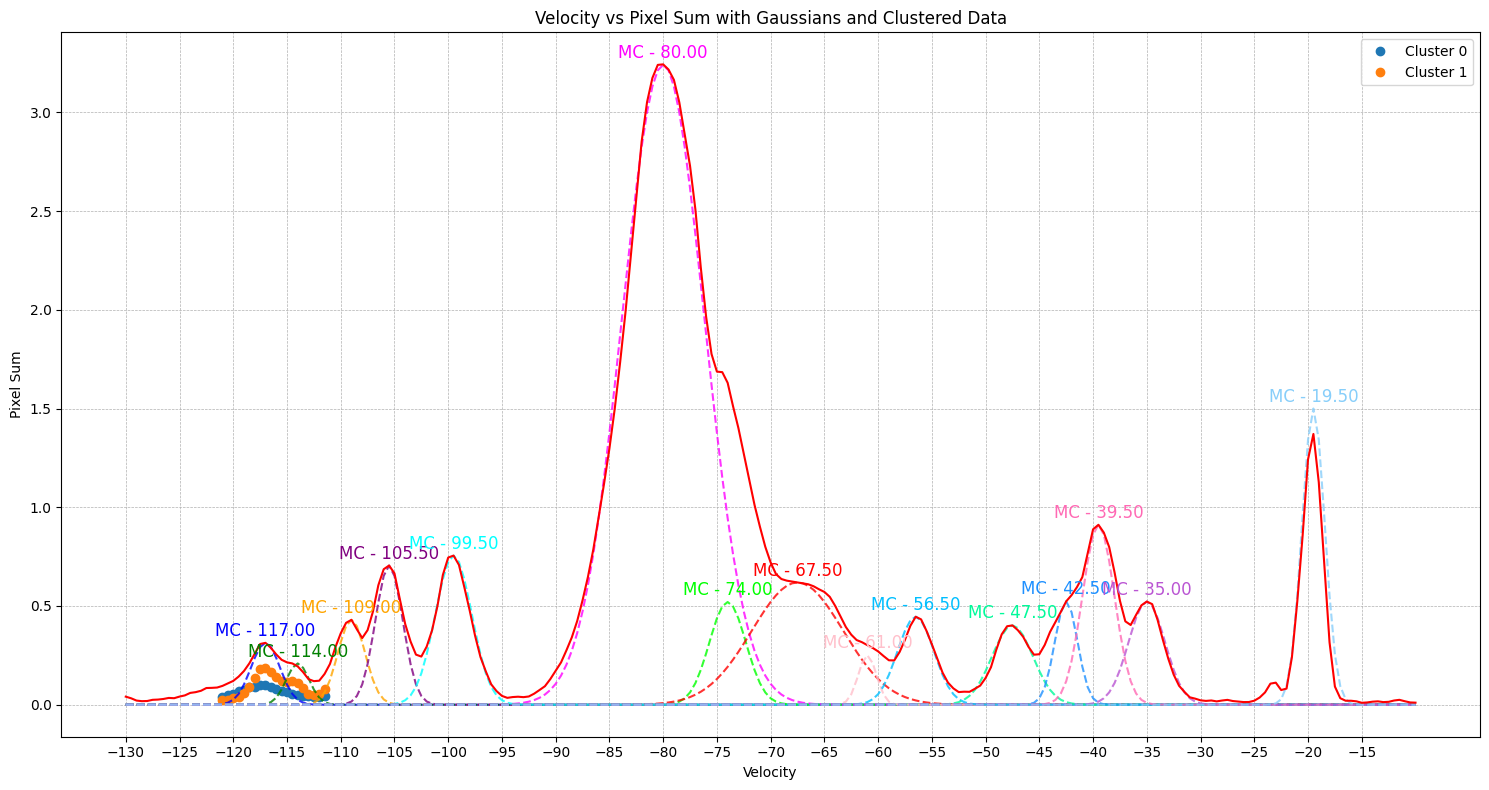

In [112]:
agg_df = plot_spectrum(original_dataset,labels, True)

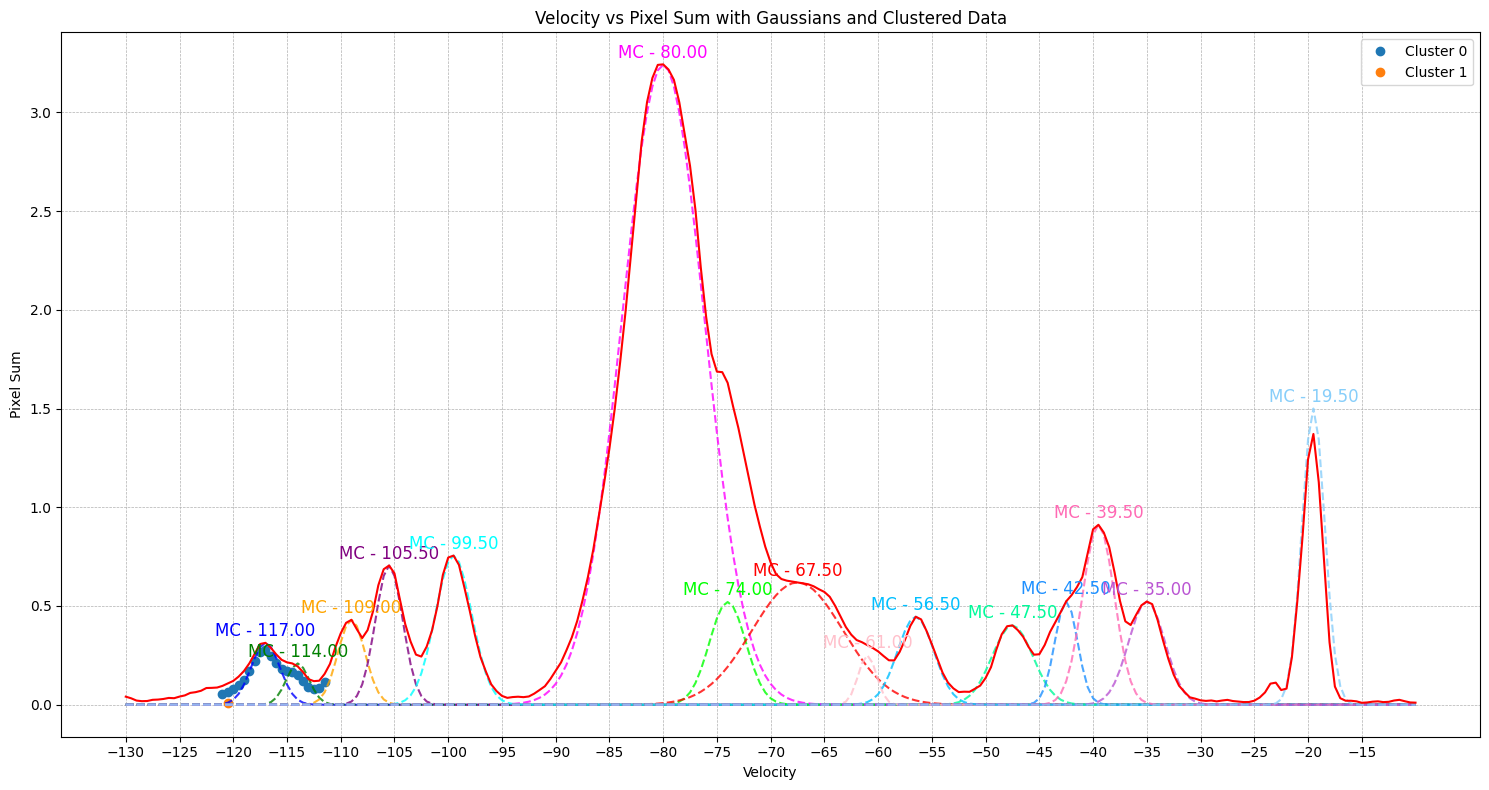

In [54]:
agg_df = plot_spectrum(original_dataset,spectral_labels, True)

In [ ]:
agg_df = plot_spectrum(original_dataset,hdbscan_labels, True)

In [ ]:
seeds = [[36, 28, -117, 4.000822],
         [3, 34, -114, 4.590847	]]

## MC 109 - 105 - 100

In [119]:
seeds = [[2, 35, -100,   5.597802],
         [34, 22, -105,  6.21070 ],
         [24, 2, -109,  6.593767 ]]

In [120]:
start_velocity = -112
end_velocity = -95

In [121]:
scaled_dataset, scaler, original_dataset = prepare_data_for_mean_shift(fits_path, start_velocity, end_velocity,
                                                         use_otsu=True, otsu_mult_factor=0.3, scaling_method='standard')

In [122]:
scaled_dataset

array([[-1.85633205, -0.17965679, -1.97359983, -0.78147442],
       [-1.85633205,  0.06740789, -1.97359983,  0.35008887],
       [-1.85633205,  0.23211767, -1.97359983,  0.93499312],
       ...,
       [ 1.92801717, -2.15617421,  1.9666645 , -1.04477098],
       [ 2.55874204, -0.34436657,  1.9666645 , -0.9695717 ],
       [ 2.55874204, -0.0973019 ,  1.9666645 , -1.04074577]])

In [123]:
scaled_seeds = scale_seeds(seeds, scaler)

In [124]:
scaled_seeds

array([[-1.7662285 ,  0.47918235,  0.80776322,  3.26246661],
       [ 1.1170852 , -0.59143125, -0.35113805,  3.77059286],
       [ 0.21604967, -2.23852911, -1.27825906,  4.08817653]])

In [90]:
n_clusters = 3  # Number of clusters

# Creating a GMM model with custom parameters
gmm_custom = GaussianMixture(n_components=n_clusters,
                             means_init=scaled_seeds)
gmm_custom.fit(scaled_dataset)


# Getting the labels and probabilities for each data point after re-training
labels = gmm_custom.predict(scaled_dataset)
retrained_probabilities = gmm_custom.predict_proba(scaled_dataset)

In [102]:
from sklearn.mixture import BayesianGaussianMixture
import numpy as np


# Number of components (maximum number of clusters)
n_components = 3

# Dirichlet process concentration parameter
dirichlet_concentration_prior = 3

# Initial guesses for means, covariances, and weights
means_init = scaled_seeds  # Adjust dimensions as per your data
weights_init = np.array([0.2, 0.4, 0.4])  # Should sum to 1

# Creating the model with Dirichlet process and initial parameters
bgmm = BayesianGaussianMixture(n_components=n_components,
                               covariance_type='diag',
                               weight_concentration_prior_type='dirichlet_process',
                               weight_concentration_prior=dirichlet_concentration_prior,
                               means_init=means_init,
                               weights_init=weights_init)
bgmm.fit(scaled_dataset)

# Getting the labels and probabilities
labels = bgmm.predict(scaled_dataset)
probabilities = bgmm.predict_proba(scaled_dataset)


TypeError: BayesianGaussianMixture.__init__() got an unexpected keyword argument 'means_init'

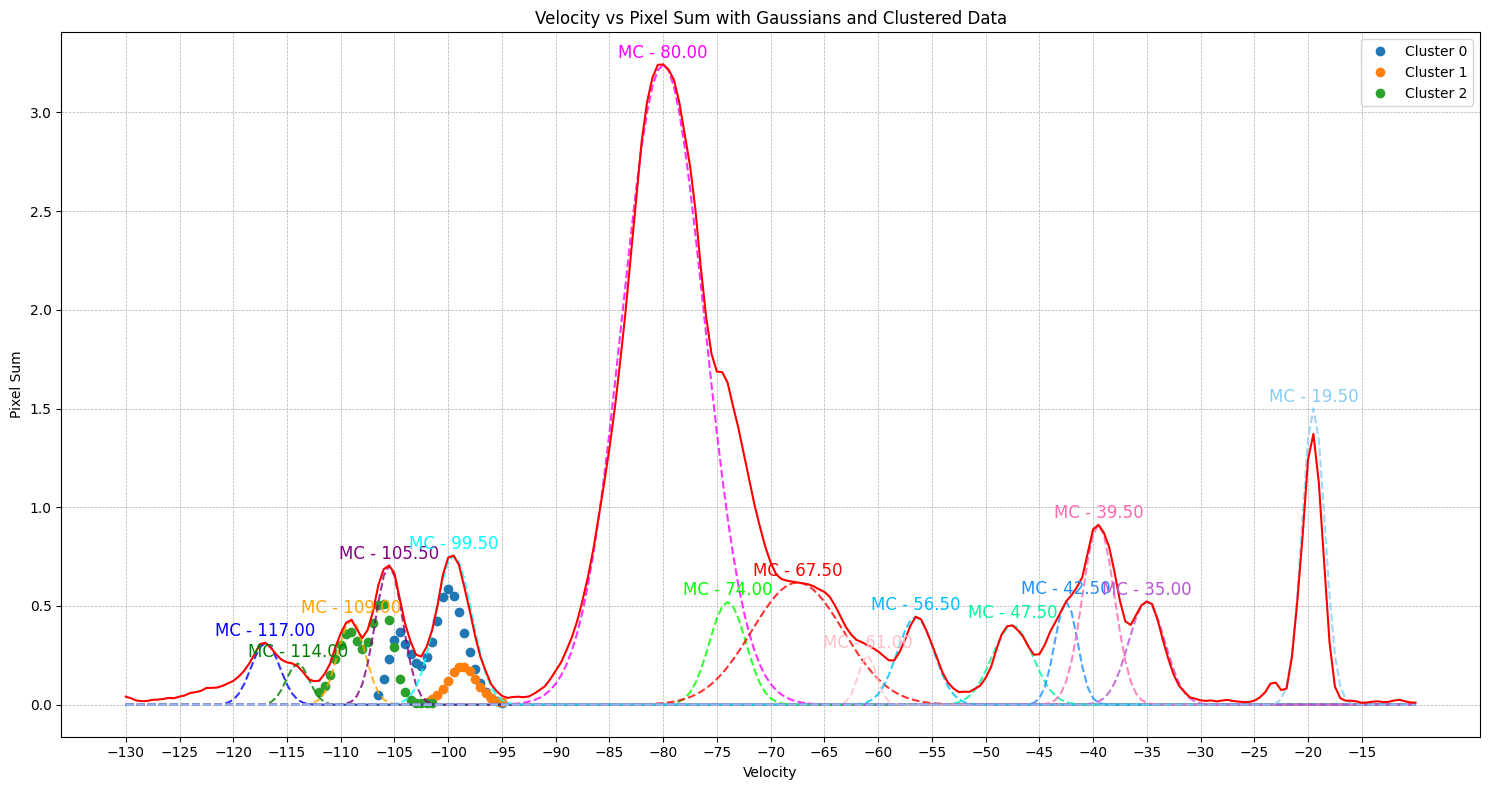

In [135]:
from sklearn.mixture import BayesianGaussianMixture
import numpy as np


# Number of components (maximum number of clusters)
n_components = 3

# Dirichlet process concentration parameter
dirichlet_concentration_prior = 3

# Creating the model with Dirichlet process
bgmm = BayesianGaussianMixture(n_components=n_components,
                              covariance_type='diag',
                              weight_concentration_prior_type='dirichlet_process',
                              weight_concentration_prior=8)
bgmm.fit(scaled_dataset)

# Getting the labels and probabilities
labels = bgmm.predict(scaled_dataset)
probabilities = bgmm.predict_proba(scaled_dataset)
agg_df = plot_spectrum(original_dataset,labels, True)

In [136]:
plot_3d_clusters_interactive(original_dataset, labels, z_range = [start_velocity-15,end_velocity+15])

Counter({0: 9101, 2: 7166, 1: 2582})


In [94]:
from sklearn.mixture import BayesianGaussianMixture

n_clusters = 3

bgmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='diag',
                               weight_concentration_prior_type='dirichlet_process',
                               weight_concentration_prior=3)
bgmm.fit(scaled_dataset)

# Getting the labels and probabilities for each data point
gmmlabels = bgmm.predict(scaled_dataset)
probabilities = bgmm.predict_proba(scaled_dataset)


In [78]:
from sklearn.cluster import SpectralClustering
import numpy as np

n_clusters = 3 # Number of clusters to specify

# Creating and fitting the Spectral Clustering model
spectral_model = SpectralClustering(n_clusters=n_clusters, gamma=10.0)
spectral_labels = spectral_model.fit_predict(scaled_dataset)

spectral_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

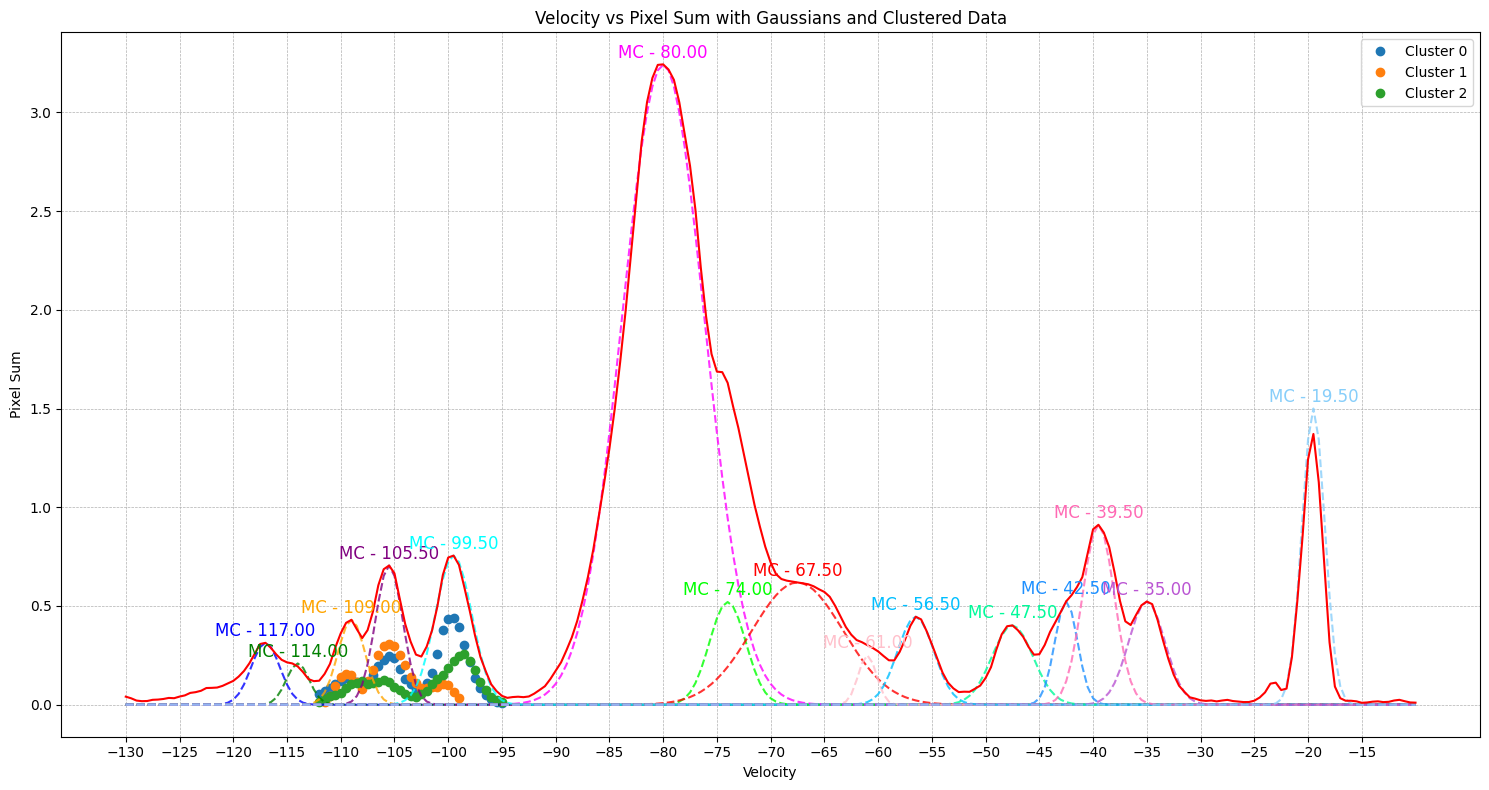

In [79]:
agg_df = plot_spectrum(original_dataset,labels, True)

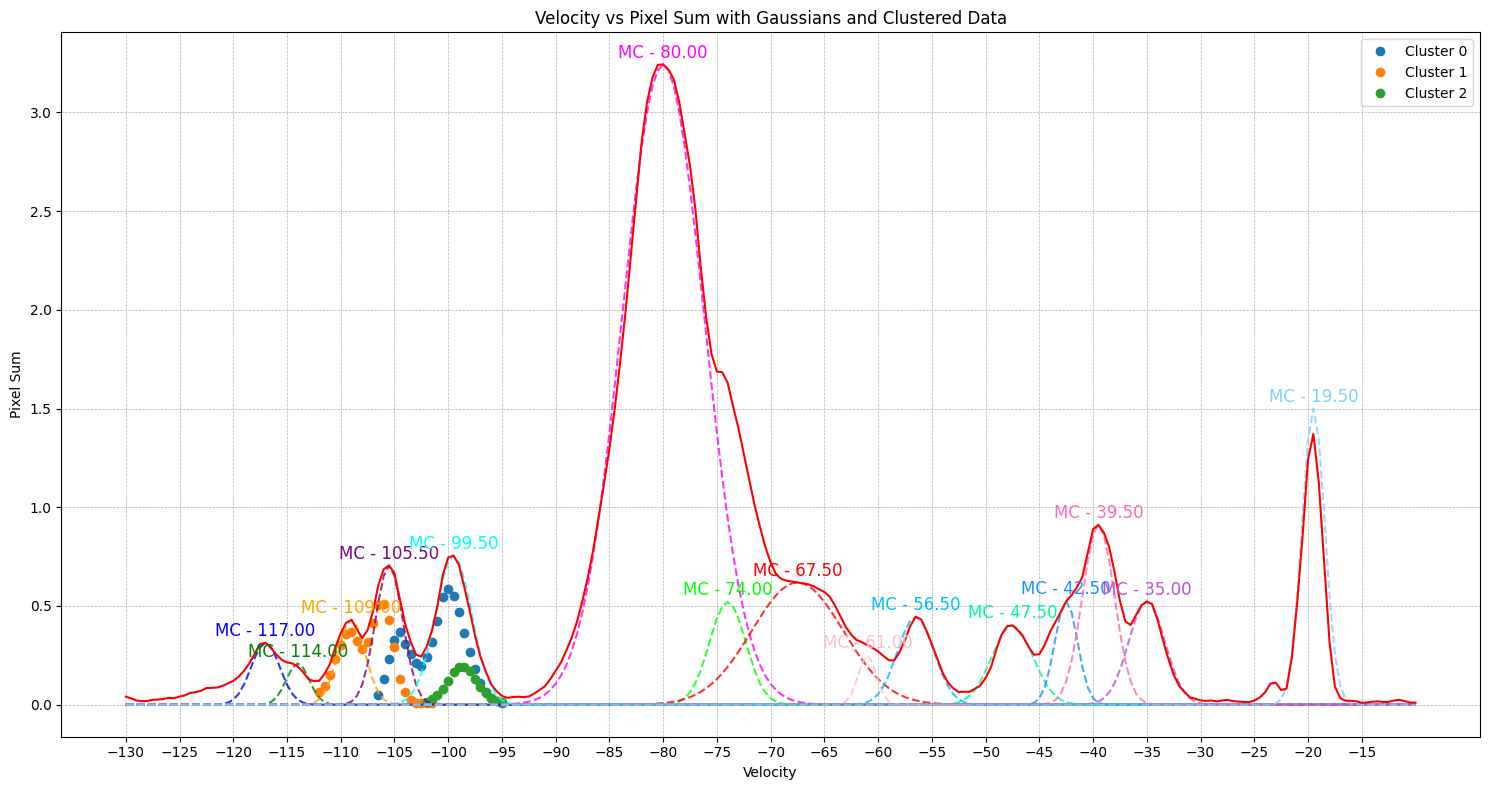

In [95]:
agg_df = plot_spectrum(original_dataset,gmmlabels, True)

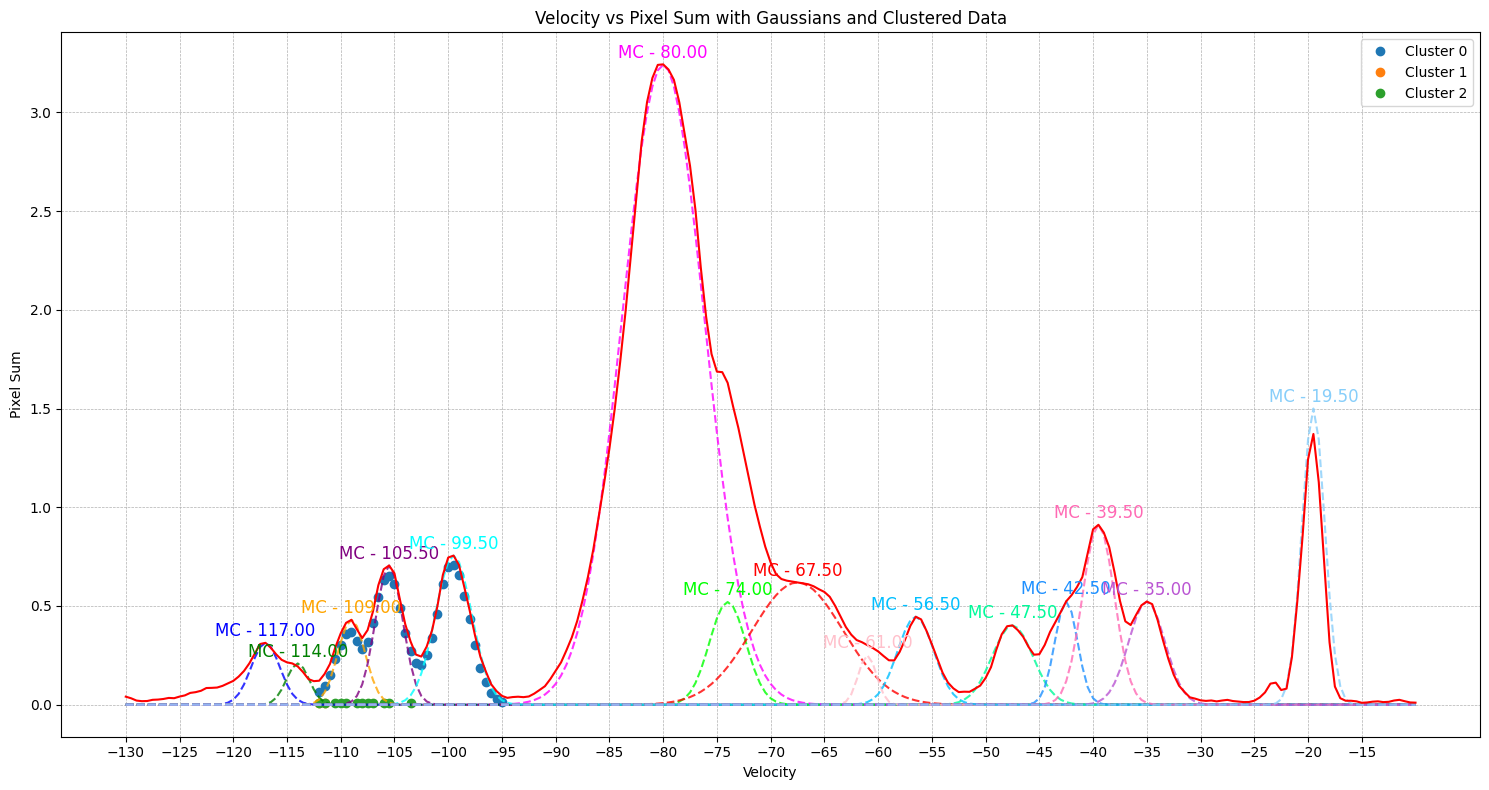

In [93]:
agg_df = plot_spectrum(original_dataset,spectral_labels, True)

## MC 80 - 74 - 67 - 61 - 56

In [113]:
seeds = [[5, 2, -80, 11.789562	  ],
         [18, 95, -73, 3.884139	  ],
         [26, 40, -68, 10.8933067 ],
         [12, 14, -61, 4.530908		],
         [6, 13, -56, 4.385234    ]]

In [114]:
from sklearn.mixture import GaussianMixture

In [115]:
start_velocity = -95
end_velocity = -52

In [116]:
scaled_dataset, scaler, original_dataset = prepare_data_for_mean_shift(fits_path, start_velocity, end_velocity,
                                                         use_otsu=True, otsu_mult_factor=0.3, scaling_method='standard')

In [117]:
scaled_dataset

array([[-1.12210019, -1.70295994, -2.49298323, -0.90477579],
       [-1.12210019, -1.62517105, -2.49298323, -0.92617928],
       [-1.12210019, -1.54738215, -2.49298323, -1.01289477],
       ...,
       [ 2.06856829, -1.15843768,  3.06761235, -1.0225236 ],
       [ 2.06856829, -1.08064879,  3.06761235, -0.73770687],
       [ 2.06856829, -1.00285989,  3.06761235, -0.73538181]])

In [133]:
scaled_dataset[:, 2] = scaled_dataset[:, 2] * 11

In [118]:
scaled_seeds = scale_seeds(seeds, scaler)

In [119]:
scaled_seeds

array([[-1.34470497, -1.62517105, -0.55324059,  5.40692639],
       [-0.38008427,  5.60919612,  0.35197264,  0.824007  ],
       [ 0.21352848,  1.33080693,  0.99855352,  4.88735068],
       [-0.82529382, -0.69170432,  1.90376676,  1.1989509 ],
       [-1.27050338, -0.76949321,  2.55034764,  1.114501  ]])

In [134]:
scaled_seeds[:, 2] = scaled_seeds[:, 2] * 11

In [120]:
gmm_default = GaussianMixture()
gmm_default.fit(scaled_dataset)

# Printing the number of components, means, and weights for the default model
default_n_components = gmm_default.n_components
default_means = gmm_default.means_
default_weights = gmm_default.weights_


In [121]:
# Getting the labels and probabilities for each data point after re-training
labels = gmm_default.predict(scaled_dataset)
retrained_probabilities = gmm_default.predict_proba(scaled_dataset)


In [136]:
n_clusters = 5 # Number of clusters

# Creating a GMM model with custom parameters
gmm_custom = GaussianMixture(n_components=n_clusters,
                             means_init=scaled_seeds)
gmm_custom.fit(scaled_dataset)


# Getting the labels and probabilities for each data point after re-training
labels = gmm_custom.predict(scaled_dataset)
retrained_probabilities = gmm_custom.predict_proba(scaled_dataset)

ValueError: The parameter 'means' should have the shape of (4, 4), but got (5, 4)

In [139]:
from sklearn.mixture import BayesianGaussianMixture

n_clusters = 6

bgmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='diag',
                               weight_concentration_prior_type='dirichlet_process')
bgmm.fit(scaled_dataset)

# Getting the labels and probabilities for each data point
labels = bgmm.predict(scaled_dataset)
probabilities = bgmm.predict_proba(scaled_dataset)


/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



In [ ]:
retrained_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
default_n_components

1

In [ ]:
default_means

array([[ 1.43943831e-17,  5.75775324e-17,  1.07478060e-15,
        -6.71737878e-17]])

In [ ]:
default_weights

array([1.])

In [ ]:
plot_3d_clusters_interactive(original_dataset, retrained_labels, z_range = [start_velocity-15,end_velocity+15])

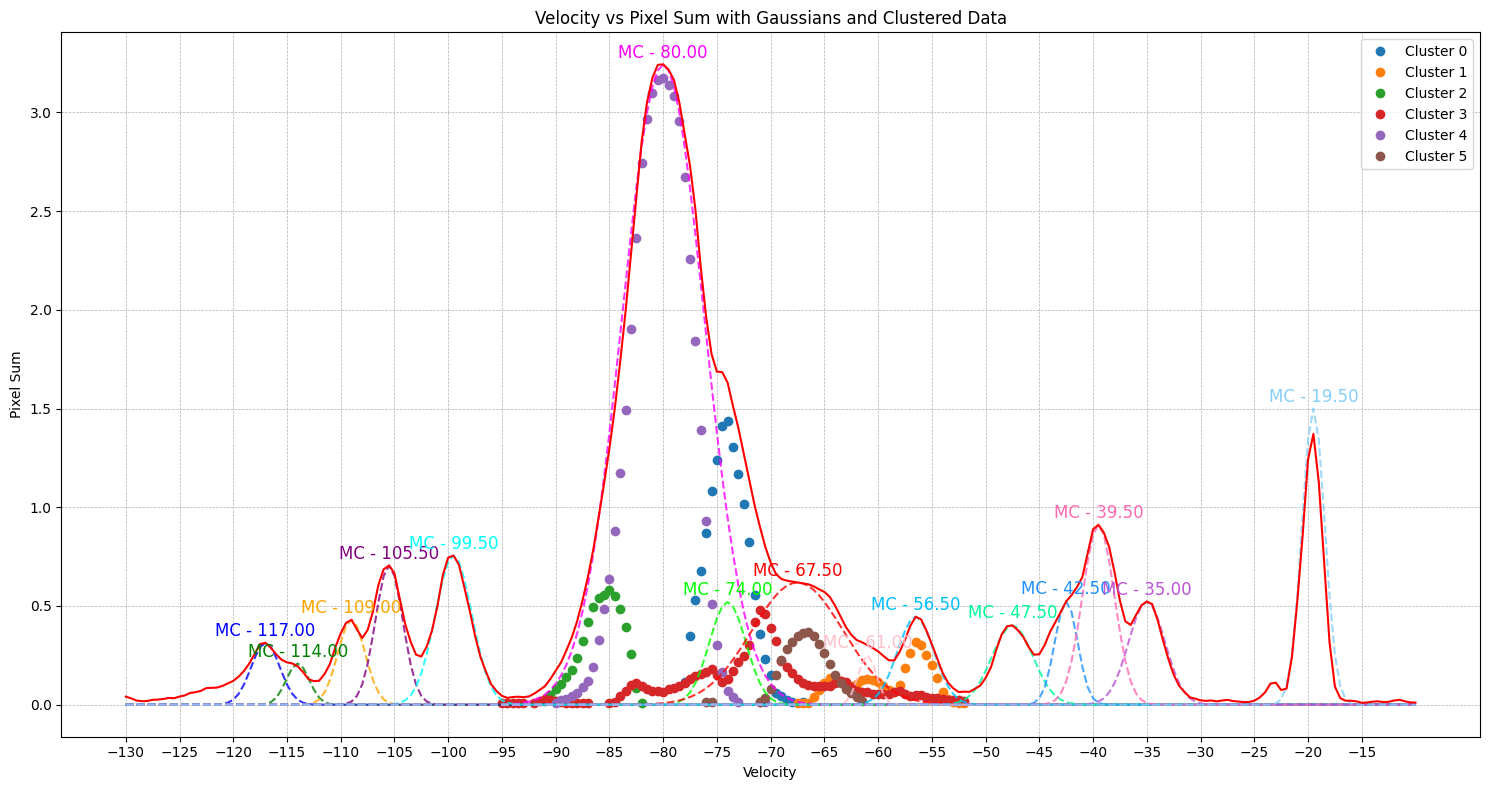

In [140]:
agg_df = plot_spectrum(original_dataset,labels, True)

In [ ]:
seeds = [[36, 28, -117, 4.000822],
         [3, 34, -114, 4.590847	]]

## MC 47 - 42 - 39 - 35

In [ ]:
seeds = [[13, 42, -47, 4.081348 ],
         [11, 43, -42, 6.984776	],
         [20, 27, -39, 2.355332 ],
         [12, 1, -35, 2.021111  ]]
